In [1]:
from vocab import Vocabulary
from model import EncoderCNN, DecoderRNN 
from torch.autograd import Variable 
from PIL import Image
from configuration import Config
from data import get_data_loader
import argparse
import torch
import numpy as np 
import pickle 
import os
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# Configuration for hyper-parameters
config = Config()

# Image Preprocessing
transform = config.test_transform

# Load vocabulary
with open(os.path.join(config.vocab_path, 'vocab.pkl'), 'rb') as f:
    vocab = pickle.load(f)

# Build Models
encoder = EncoderCNN(config.embed_size)
decoder = DecoderRNN(config.embed_size, config.hidden_size, 
                     len(vocab), config.num_layers)
encoder.eval()   # evaluation mode (BN uses moving mean/variance)


# Load the trained model parameters
encoder.load_state_dict(torch.load(os.path.join(config.model_path, 
                                                config.trained_encoder)))
decoder.load_state_dict(torch.load(os.path.join(config.model_path, 
                                                config.trained_decoder)))

In [3]:
# Build data loader
image_path = os.path.join(config.image_path, 'val2014')
json_path = os.path.join(config.caption_path, 'captions_val2014.json')
test_loader = get_data_loader(image_path, json_path, vocab, 
                               transform, config.batch_size,
                               shuffle=False, num_workers=config.num_threads) 

# Select mini-batch images
data_iter = iter(test_loader)
images, _, _ = data_iter.next()
images = Variable(images)

loading annotations into memory...
Done (t=0.33s)
creating index...
index created!


In [4]:
# Set initial states
states = (Variable(torch.zeros(config.num_layers, config.batch_size, config.hidden_size)),
         Variable(torch.zeros(config.num_layers, config.batch_size, config.hidden_size)))

# If use gpu
if torch.cuda.is_available():
    encoder.cuda()
    decoder.cuda()
    states = [s.cuda() for s in states]
    images = images.cuda()
    
# Forward prop the model
features = encoder(images)
sampled_ids = decoder.sample(features, states)
sampled_ids = sampled_ids.cpu().data.numpy()

<start> a baby is brushing his teeth with a toothbrush . <end>


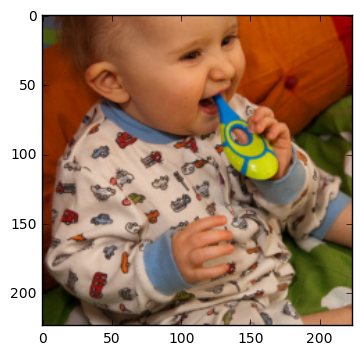

In [5]:
# Decode ids to words (You can change the index below).
idx = 33
plt.imshow(images.cpu().data.numpy()[idx].transpose(1, 2, 0) * 0.5 + 0.5)
sampled_caption = []
for word_id in sampled_ids[idx]:
    word = vocab.idx2word[word_id]
    sampled_caption.append(word)
    if word == '<end>':
        break
sentence = ' '.join(sampled_caption)
print (sentence)